In [47]:
## Kind of working version with 3 unknown cells (outputs something, but has some errors in the output values) 

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

## Helper Functions

def mark_equal_2qubits(qc, var_qubits, cellA, cellB, target, anc1, anc2):
    """
    Mark 'target' ancilla if cellA == cellB.
    """
    def get_qubits(cell):
        # Map a cell index to its var_qubits indices.
        if cell in unknown_cells:
            return [var_qubits[i] for i in [2*unknown_cells.index(cell), 2*unknown_cells.index(cell) + 1]]
        else:
            return [(known_cells[cell] >> 1) & 1, known_cells[cell] & 1]
    
    qa = get_qubits(cellA)
    qb = get_qubits(cellB)
    
    # Step 1: Check bit0 equality
    if isinstance(qa[0], int) and isinstance(qb[0], int):
        # If both are known cells, compare their values directly
        if qa[0] == qb[0]:
            qc.x(target) # If equal, mark target
        else:
            return
    else:
        if isinstance(qa[0], int):
            # If qa[0] is a known cell and qb[0] is quantum
            if qa[0] == 0:
                # If qa[0] = 0, use qb[0] to control anc1.
                qc.cx(qb[0], anc1) 
            else:
                # If qa[0] = 1, use flipped qb[0] to control anc1 and flip it back.
                qc.x(qb[0]) 
                qc.cx(qb[0], anc1)
                qc.x(qb[0])
        elif isinstance(qb[0], int):
            # If qb[0] is a known cell and qa[0] is quantum
            if qb[0] == 0:
                qc.cx(qa[0], anc1)
            else:
                qc.x(qa[0])
                qc.cx(qa[0], anc1)
                qc.x(qa[0])
        else:
            # If both are quantum,
            qc.cx(qa[0], anc1)
            qc.cx(qb[0], anc1)
        qc.x(anc1)

    # Step 2: Check bit1 equality
    if isinstance(qa[1], int) and isinstance(qb[1], int):
        if qa[1] == qb[1]:
            qc.x(target) # If equal, mark target
        else:
            if isinstance(qa[0], int) and isinstance(qb[0], int) and (qa[0] == qb[0]):
                qc.x(target)  # undo extra flips
            return
    else:
        if isinstance(qa[1], int):
            if qa[1] == 0:
                qc.cx(qb[1], anc2)
            else:
                qc.x(qb[1])
                qc.cx(qb[1], anc2)
                qc.x(qb[1])
        elif isinstance(qb[1], int):
            if qb[1] == 0:
                qc.cx(qa[1], anc2)
            else:
                qc.x(qa[1])
                qc.cx(qa[1], anc2)
                qc.x(qa[1])
        else:
            qc.cx(qa[1], anc2)
            qc.cx(qb[1], anc2)
        qc.x(anc2)

    # Step 3: If both bit 0 and bit 1 matched, mark target
    qc.ccx(anc1, anc2, target) 

    # Uncompute ancillas
    qc.x(anc1)
    qc.x(anc2)
    if not (isinstance(qa[0], int) and isinstance(qb[0], int)):
        qc.cx(qa[0], anc1)
        qc.cx(qb[0], anc1)
    if not (isinstance(qa[1], int) and isinstance(qb[1], int)):
        qc.cx(qa[1], anc2)
        qc.cx(qb[1], anc2)

def mark_conflict_rc(qc, var_qubits, rc_cells, ancilla, ancillas_pool):
    """
    Mark the ancilla if any two cells in rc_cells are equal.
    """
    pairs = [] # pairs of cells to compare
    for i in range(len(rc_cells)):
        for j in range(i+1, len(rc_cells)):
            pairs.append((rc_cells[i], rc_cells[j]))

    # Mark each pair of cells if they are equal.
    temp_anc = ancillas_pool[0]

    for cA, cB in pairs:
        qc.reset(temp_anc)
        mark_equal_2qubits(qc, var_qubits, cA, cB, temp_anc, ancillas_pool[1], ancillas_pool[2])
        qc.cx(temp_anc, ancilla)
        mark_equal_2qubits(qc, var_qubits, cA, cB, temp_anc, ancillas_pool[1], ancillas_pool[2])

def apply_oracle(qc, var_qubits, output, rc_ancillas, temp_ancillas, rcs):
    for anc in rc_ancillas:
        qc.reset(anc)
    for i, rc in enumerate(rcs):
        # For each RC, mark conflicts
        mark_conflict_rc(qc, var_qubits, rc, rc_ancillas[i], temp_ancillas)
    for anc in rc_ancillas:
        # Flip ancillas so each ancilla is 1 if the rc is valid.
        qc.x(anc)
    # MXC to flip output if all ancillas are 1.
    qc.mcx(rc_ancillas, output[0])
    # Undo the flips on ancillas.
    for anc in rc_ancillas:
        qc.x(anc)

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.h(range(nqubits))
    qc.x(range(nqubits))
    qc.h(nqubits - 1)
    qc.mcx(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    qc.x(range(nqubits))
    qc.h(range(nqubits))
    return qc


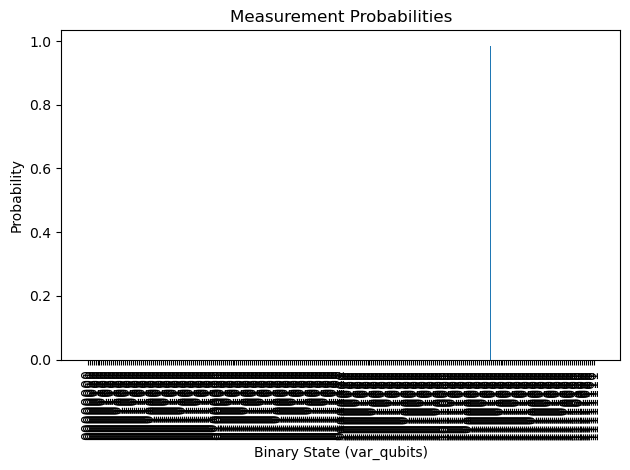

In [58]:
## TODO: User Input
## Known cells (fixed values)
known_cells = {
    0: 2, 1: 0, 2: 1, 3: 3,
    4: 1, 5: 3, 6: 2, 7: 0,
    8: 0, 9: 1, 10: 3, 
    12: 3
}
unknown_cells = [11, 13, 14, 15]  # Three unknown cells

# --- Quantum Circuit Setup ---

# Reduced RC groups for constraints
rcs = [
    [8,9,10,11], [1,5,9,13], [2,6,10,14], [3,7,11,15]
]

#rcs = [
#    [0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15],
#    [0,4,8,12], [1,5,9,13], [2,6,10,14], [3,7,11,15],
#    [0,1,4,5], [2,3,6,7], [8,9,12,13], [10,11,14,15]
#]

num_vars = 2 * len(unknown_cells)  
var_qubits = QuantumRegister(num_vars, 'v')
rc_ancillas = AncillaRegister(len(rcs), 'anc_rc')  # ancillas for each RC group
temp_ancillas = AncillaRegister(4, 'anc_temp')  # temp ancillas
output = QuantumRegister(1, 'out') # output qubit for marking conflicts

qc = QuantumCircuit(var_qubits, rc_ancillas, temp_ancillas, output)

# Initialize superposition on variable qubits
qc.initialize([1, -1]/np.sqrt(2), output)
qc.h(var_qubits)
qc.barrier()


# Apply Grover iterations
N = 4**3
num_iterations = 10#int(np.floor(np.pi/4 * np.sqrt(N)))  # ~6 iterations
for _ in range(num_iterations):
    apply_oracle(qc, var_qubits, output, rc_ancillas, temp_ancillas, rcs)
    qc.append(diffuser(len(var_qubits)), var_qubits[:])

# Final statevector and probabilities
final_state = Statevector.from_instruction(qc)
probs = final_state.probabilities(qargs=range(num_vars))  # indices of var_qubits

# --- Plotting ---
num_var_qubits = len(var_qubits)
labels = [format(i, f'0{num_var_qubits}b') for i in range(2**num_var_qubits)]
plt.bar(labels, probs)
plt.xlabel('Binary State (var_qubits)')
plt.ylabel('Probability')
plt.title('Measurement Probabilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [57]:
# Get labels and probabilities together
labeled_probs = list(zip(labels, probs))

# Sort by probability descending
labeled_probs.sort(key=lambda x: x[1], reverse=True)

# Print top results
print("Most probable bitstrings (variable qubits only):")
for label, prob in labeled_probs:
    if prob > 1e-3:
        print(f"{label} → {prob:.4f}")


Most probable bitstrings (variable qubits only):
10001011 → 0.4845
01001011 → 0.4845
